# Modeling Exercises

Do your work for this exercise in a jupyter notebook named modeling within the regression-exercises repo. Add, commit, and push your work.

Select a dataset with a continuous target variable.

Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from math import sqrt
from scipy.stats import pearsonr, spearmanr

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LassoLars, LinearRegression, TweedieRegressor

import wrangle
import evaluate
import modeling

import warnings
warnings.filterwarnings("ignore")

## Acquiring, prep, and subsetting data

In [2]:
df = wrangle.get_zillow()

In [3]:
cols = ['bedrooms', 'bathrooms', 'square_ft', 'built', 'taxamount', 'fips']

df = wrangle.remove_outliers(df, 3, cols)

In [4]:
df.head()

,bedrooms,bathrooms,square_ft,tax_value,built,taxamount,fips
0,4,2.0,3633,296425,2005,6941.39,6037
1,3,4.0,1620,847770,2011,10244.94,6037
2,3,2.0,2077,646760,1926,7924.68,6037
6,3,1.0,1244,169471,1950,2532.88,6037
7,3,2.0,1300,233266,1950,3110.99,6037


In [5]:
train, validate, test = wrangle.subset_df(df)

train.shape, validate.shape, test.shape

((1230486, 7), (410162, 7), (410162, 7))

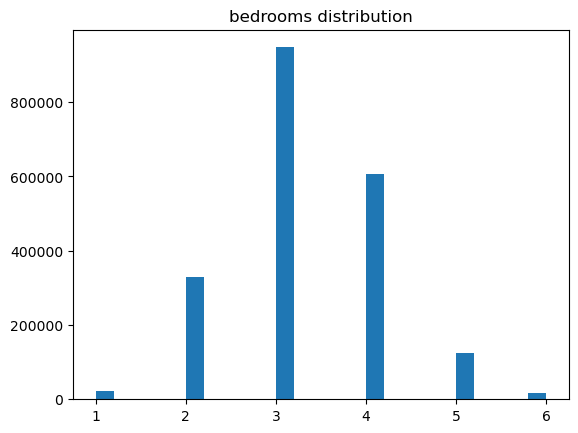

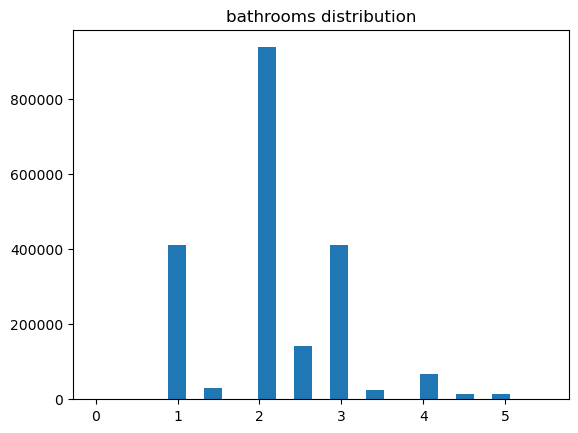

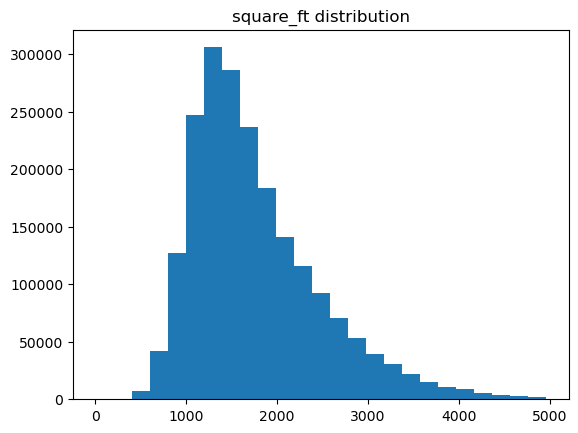

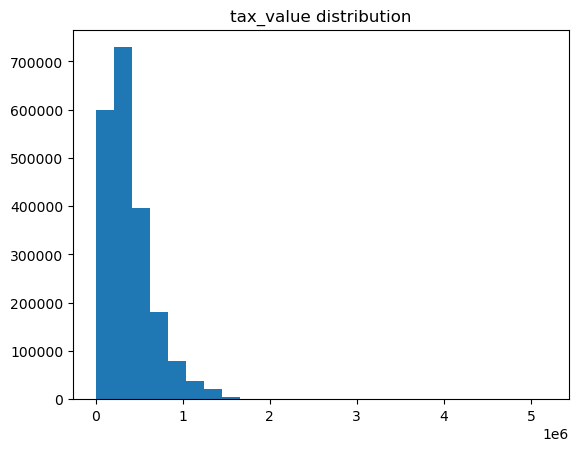

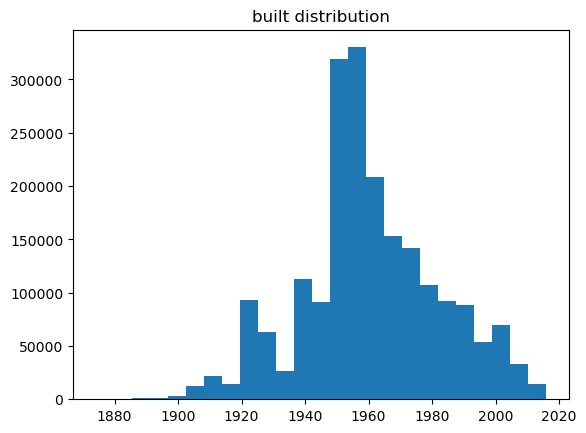

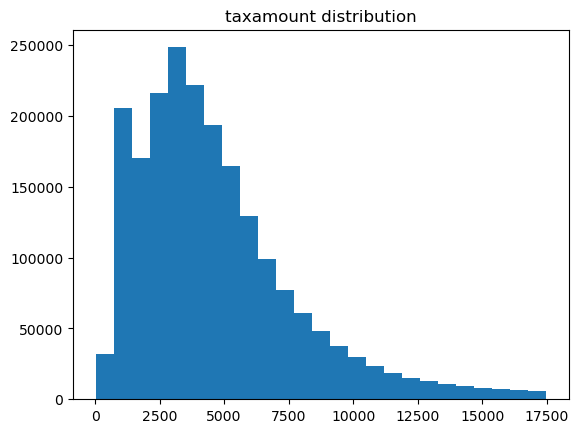

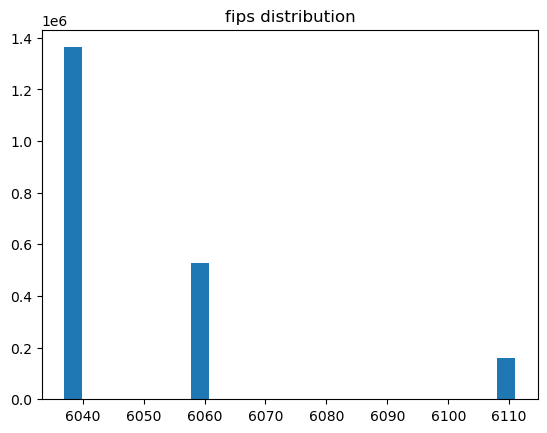

In [48]:
for col in df:

    plt.hist(df[col], bins=25)
    plt.title(f'{col} distribution')
    plt.show()

In [6]:
X_train, y_train, X_validate, y_validate, X_test, y_test = modeling.xy_subsets(train, validate, test, 'tax_value')

In [7]:
X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape

((1230486, 6), (1230486,), (410162, 6), (410162,), (410162, 6), (410162,))

## scaling data

In [9]:
mms = MinMaxScaler()

X_train[['square_ft', 'taxamount']] = mms.fit_transform(train[['square_ft', 'taxamount']])

In [12]:
X_train = pd.get_dummies(X_train, columns=['bedrooms', 'bathrooms', 'fips'])

In [15]:
X_train.head()

,square_ft,built,taxamount,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bathrooms_0.0,...,bathrooms_2.5,bathrooms_3.0,bathrooms_3.5,bathrooms_4.0,bathrooms_4.5,bathrooms_5.0,bathrooms_5.5,fips_6037,fips_6059,fips_6111
1709747,0.243902,1954,0.302212,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1531191,0.250151,1962,0.097395,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1911842,0.226366,1948,0.171172,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1556357,0.216690,1923,0.023359,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1916043,0.195525,1948,0.098613,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## feature engineering and selection

In [16]:
lm = LinearRegression()
rfe = RFE(lm, n_features_to_select=7)

rfe.fit(X_train, y_train)

ranks = rfe.ranking_
columns = X_train.columns.tolist()

In [25]:
feature_ranks = pd.DataFrame({'ranking': ranks,
                              'feature': columns})

feature_ranks = feature_ranks.sort_values('ranking')

feature_ranks.head(7)

,ranking,feature
24,1,fips_6111
22,1,fips_6037
21,1,bathrooms_5.5
20,1,bathrooms_5.0
19,1,bathrooms_4.5
17,1,bathrooms_3.5
23,1,fips_6059


In [51]:
X_train1 = X_train[['fips_6111', 'fips_6037', 'bathrooms_5.5', 'bathrooms_5.0', 'bathrooms_4.5', 'bathrooms_3.5', 'fips_6059']]

In [54]:
X_train1.head()

,fips_6111,fips_6037,bathrooms_5.5,bathrooms_5.0,bathrooms_4.5,bathrooms_3.5,fips_6059
1709747,0,0,0,0,0,0,1
1531191,1,0,0,0,0,0,0
1911842,0,1,0,0,0,0,0
1556357,0,1,0,0,0,0,0
1916043,1,0,0,0,0,0,0


In [22]:
f_selector = SelectKBest(f_regression, k=7)

f_selector.fit(X_train, y_train)

f_select_mask = f_selector.get_support()

select_k_best_features = X_train.iloc[:,f_select_mask]

select_k_best_features.head()

,square_ft,built,taxamount,bathrooms_1.0,bathrooms_2.0,bathrooms_3.0,bathrooms_4.0
1709747,0.243902,1954,0.302212,0,1,0,0
1531191,0.250151,1962,0.097395,0,1,0,0
1911842,0.226366,1948,0.171172,1,0,0,0
1556357,0.216690,1923,0.023359,1,0,0,0
1916043,0.195525,1948,0.098613,1,0,0,0


In [59]:
X_train2 = X_train[['square_ft', 'built', 'taxamount', 'bathrooms_1.0', 'bathrooms_2.0', 'bathrooms_3.0', 'bathrooms_4.0']]

In [60]:
X_train2.head()

,square_ft,built,taxamount,bathrooms_1.0,bathrooms_2.0,bathrooms_3.0,bathrooms_4.0
1709747,0.243902,1954,0.302212,0,1,0,0
1531191,0.250151,1962,0.097395,0,1,0,0
1911842,0.226366,1948,0.171172,1,0,0,0
1556357,0.216690,1923,0.023359,1,0,0,0
1916043,0.195525,1948,0.098613,1,0,0,0


## modeling - on full dataset

### OLS model

In [26]:
lm.fit(X_train, y_train)

lm_preds = lm.predict(X_train)

preds_df = pd.DataFrame({'actual': y_train,
                         'lm_preds': lm_preds})

#### making baseline

In [30]:
preds_df['baseline_avg'] = y_train.mean()

,actual,lm_preds,baseline,baseline_avg
1709747,456862,457638.585241,377492.051987,377492.051987
1531191,344734,159027.184334,377492.051987,377492.051987
1911842,238835,219983.927383,377492.051987,377492.051987
1556357,37228,16298.571753,377492.051987,377492.051987
1916043,142954,158864.764587,377492.051987,377492.051987


In [42]:
sqrt(mean_squared_error(preds_df['actual'], preds_df['baseline_avg']))

270188.7793514787

In [31]:
preds_df['baseline_median'] = y_train.median()

In [43]:
sqrt(mean_squared_error(preds_df['actual'], preds_df['baseline_median']))

276931.33800905664

In [34]:
preds_df = preds_df.drop(columns='baseline')

In [35]:
preds_df.head()

,actual,lm_preds,baseline_avg,baseline_median
1709747,456862,457638.585241,377492.051987,316755.0
1531191,344734,159027.184334,377492.051987,316755.0
1911842,238835,219983.927383,377492.051987,316755.0
1556357,37228,16298.571753,377492.051987,316755.0
1916043,142954,158864.764587,377492.051987,316755.0


In [36]:
lm_rmse = sqrt(mean_squared_error(preds_df['lm_preds'], preds_df['actual']))

lm_rmse

58944.74419879954

### lassolars model

In [40]:
lasso = LassoLars(alpha=.1)

lasso.fit(X_train, y_train)

lasso_preds = lasso.predict(X_train)

preds_df['lasso_preds'] = lasso_preds

preds_df.head()

,actual,lm_preds,baseline_avg,baseline_median,lasso_preds
1709747,456862,457638.585241,377492.051987,316755.0,457430.929631
1531191,344734,159027.184334,377492.051987,316755.0,158613.485895
1911842,238835,219983.927383,377492.051987,316755.0,220702.550679
1556357,37228,16298.571753,377492.051987,316755.0,16712.120588
1916043,142954,158864.764587,377492.051987,316755.0,159151.641261


In [41]:
lasso_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['lasso_preds']))
lasso_rmse

58947.79652923888

### polynomial regression

In [44]:
pf = PolynomialFeatures(degree=2)

pf.fit(X_train, y_train)

X_polynomial = pf.transform(X_train)

#### ols model /w polynomial regression

In [45]:
lm2 = LinearRegression()

lm2.fit(X_polynomial, y_train)

preds_df['poly_preds'] = lm2.predict(X_polynomial)

preds_df.head()

,actual,lm_preds,baseline_avg,baseline_median,lasso_preds,poly_preds
1709747,456862,457638.585241,377492.051987,316755.0,457430.929631,448964.618961
1531191,344734,159027.184334,377492.051987,316755.0,158613.485895,147756.388467
1911842,238835,219983.927383,377492.051987,316755.0,220702.550679,228577.082747
1556357,37228,16298.571753,377492.051987,316755.0,16712.120588,13222.339583
1916043,142954,158864.764587,377492.051987,316755.0,159151.641261,148003.825967


In [61]:
lm2_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['poly_preds']))

lm2_rmse

56673.649224723005

#### lasso-lars model /w polynomial regression

In [62]:
lasso2 = LassoLars(alpha=.1)

lasso2.fit(X_polynomial, y_train)

lasso2_preds = lasso2.predict(X_polynomial)

preds_df['lasso_poly'] = lasso2_preds

preds_df.head()

,actual,lm_preds,baseline_avg,baseline_median,lasso_preds,poly_preds,lasso_poly
1709747,456862,457638.585241,377492.051987,316755.0,457430.929631,448964.618961,452366.736438
1531191,344734,159027.184334,377492.051987,316755.0,158613.485895,147756.388467,148469.599807
1911842,238835,219983.927383,377492.051987,316755.0,220702.550679,228577.082747,225012.587221
1556357,37228,16298.571753,377492.051987,316755.0,16712.120588,13222.339583,22761.967858
1916043,142954,158864.764587,377492.051987,316755.0,159151.641261,148003.825967,147470.094911


In [63]:
lasso2_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['lasso_poly']))

lasso2_rmse

58358.07316410397

### GLM model

(array([9.40795e+05, 2.50618e+05, 3.80830e+04, 9.56000e+02, 2.00000e+01,
        5.00000e+00, 5.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([2.2000000e+01, 5.1778710e+05, 1.0355522e+06, 1.5533173e+06,
        2.0710824e+06, 2.5888475e+06, 3.1066126e+06, 3.6243777e+06,
        4.1421428e+06, 4.6599079e+06, 5.1776730e+06]),
 <BarContainer object of 10 artists>)

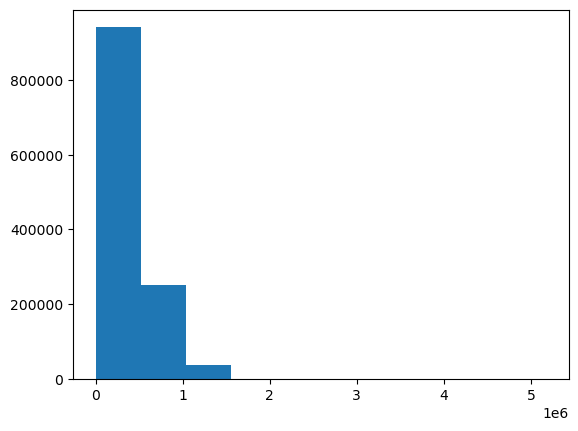

In [64]:
plt.hist(y_train)

#### tweedie - power=0 (normal)

In [74]:
preds_df = preds_df.drop(columns='tweedie_preds')

In [ ]:
tweedie = TweedieRegressor(power=0)

tweedie.fit(X_train, y_train)

tweedie_preds = tweedie.predict(X_train)

preds_df['tweedie_norm_preds'] = tweedie_preds

In [75]:
preds_df.head()

,actual,lm_preds,baseline_avg,baseline_median,lasso_preds,poly_preds,lasso_poly,tweedie_norm_preds,tweedie_poisson_preds
1709747,456862,457638.585241,377492.051987,316755.0,457430.929631,448964.618961,452366.736438,351444.745981,377492.051987
1531191,344734,159027.184334,377492.051987,316755.0,158613.485895,147756.388467,148469.599807,360063.916818,377492.051987
1911842,238835,219983.927383,377492.051987,316755.0,220702.550679,228577.082747,225012.587221,321754.668075,377492.051987
1556357,37228,16298.571753,377492.051987,316755.0,16712.120588,13222.339583,22761.967858,241170.941739,377492.051987
1916043,142954,158864.764587,377492.051987,316755.0,159151.641261,148003.825967,147470.094911,321965.035315,377492.051987


In [78]:
tweedie_norm = sqrt(mean_squared_error(preds_df['actual'], preds_df['tweedie_norm_preds']))

tweedie_norm

248443.15444986452

#### tweedie - power=1 (poisson)

In [ ]:
tweedie = TweedieRegressor(power=1)

tweedie.fit(X_train, y_train)

tweedie_preds = tweedie.predict(X_train)

preds_df['tweedie_poisson_preds'] = tweedie_preds

In [76]:
preds_df.head()

,actual,lm_preds,baseline_avg,baseline_median,lasso_preds,poly_preds,lasso_poly,tweedie_norm_preds,tweedie_poisson_preds
1709747,456862,457638.585241,377492.051987,316755.0,457430.929631,448964.618961,452366.736438,351444.745981,377492.051987
1531191,344734,159027.184334,377492.051987,316755.0,158613.485895,147756.388467,148469.599807,360063.916818,377492.051987
1911842,238835,219983.927383,377492.051987,316755.0,220702.550679,228577.082747,225012.587221,321754.668075,377492.051987
1556357,37228,16298.571753,377492.051987,316755.0,16712.120588,13222.339583,22761.967858,241170.941739,377492.051987
1916043,142954,158864.764587,377492.051987,316755.0,159151.641261,148003.825967,147470.094911,321965.035315,377492.051987


In [80]:
tweedie_poisson = sqrt(mean_squared_error(preds_df['actual'], preds_df['tweedie_poisson_preds']))

tweedie_poisson

270188.77935147873

In [84]:
results = pd.DataFrame({'model':['linear', 'lasso', 'linear_poly', 'lasso_poly', 'tweedie_norm', 'tweedie_poisson'],
              'rmse':[lm_rmse, lasso_rmse, lm2_rmse, lasso2_rmse, tweedie_norm, tweedie_poisson]})

In [85]:
results

,model,rmse
0,linear,58944.744199
1,lasso,58947.796529
2,linear_poly,56673.649225
3,lasso_poly,58358.073164
4,tweedie_norm,248443.154450
5,tweedie_poisson,270188.779351


## modeling - on feature engineered subsets

In [81]:
X_train1.head()

,fips_6111,fips_6037,bathrooms_5.5,bathrooms_5.0,bathrooms_4.5,bathrooms_3.5,fips_6059
1709747,0,0,0,0,0,0,1
1531191,1,0,0,0,0,0,0
1911842,0,1,0,0,0,0,0
1556357,0,1,0,0,0,0,0
1916043,1,0,0,0,0,0,0


In [82]:
X_train2.head()

,square_ft,built,taxamount,bathrooms_1.0,bathrooms_2.0,bathrooms_3.0,bathrooms_4.0
1709747,0.243902,1954,0.302212,0,1,0,0
1531191,0.250151,1962,0.097395,0,1,0,0
1911842,0.226366,1948,0.171172,1,0,0,0
1556357,0.216690,1923,0.023359,1,0,0,0
1916043,0.195525,1948,0.098613,1,0,0,0


### ols model based on rfe

In [92]:
lm = LinearRegression()

In [93]:
lm.fit(X_train1, y_train)

lm3_preds = lm.predict(X_train1)

preds_df_engi = pd.DataFrame({'actual': y_train,
                         'lm3_preds': lm3_preds})

In [94]:
preds_df_engi.head()

,actual,lm3_preds
1709747,456862,419125.118164
1531191,344734,376722.845703
1911842,238835,342990.973633
1556357,37228,342990.973633
1916043,142954,376722.845703
...,...,...
270368,698984,342990.973633
1476069,418136,419125.118164
137660,349449,419125.118164
700489,291263,342990.973633


In [96]:
lm3_rmse = sqrt(mean_squared_error(preds_df_engi['lm3_preds'], preds_df_engi['actual']))

lm3_rmse

255967.47814669818

### ols model based on selectkbest

In [101]:
lm.fit(X_train2, y_train)

lm4_preds = lm.predict(X_train2)

preds_df_engi2 = pd.DataFrame({'actual': y_train,
                         'lm4_preds': lm4_preds})

In [102]:
preds_df_engi2.head()

,actual,lm4_preds
1709747,456862,427141.195607
1531191,344734,125425.474221
1911842,238835,229405.922693
1556357,37228,19133.368448
1916043,142954,121552.700898


In [103]:
lm4_rmse = sqrt(mean_squared_error(preds_df_engi2['lm4_preds'], preds_df_engi2['actual']))

lm3_rmse

255967.47814669818

### lasso-lars model based on rfe

In [98]:
lasso = LassoLars(alpha=.1)

lasso.fit(X_train1, y_train)

lasso_preds2 = lasso.predict(X_train1)

preds_df_engi['lasso_preds'] = lasso_preds2

preds_df_engi.head()

,actual,lm3_preds,lasso_preds
1709747,456862,419125.118164,418956.178720
1531191,344734,376722.845703,376652.438193
1911842,238835,342990.973633,343113.388182
1556357,37228,342990.973633,343113.388182
1916043,142954,376722.845703,376652.438193


In [100]:
lasso2_rmse = sqrt(mean_squared_error(preds_df_engi['actual'], preds_df_engi['lasso_preds']))
lasso2_rmse

255967.5882491174

### lasso-lars based on selectkbest

In [104]:
lasso = LassoLars(alpha=.1)

lasso.fit(X_train2, y_train)

lasso_preds3 = lasso.predict(X_train2)

preds_df_engi2['lasso_preds'] = lasso_preds3

preds_df_engi2.head()

,actual,lm4_preds,lasso_preds
1709747,456862,427141.195607,427171.771206
1531191,344734,125425.474221,125686.937571
1911842,238835,229405.922693,229773.116551
1556357,37228,19133.368448,19084.110314
1916043,142954,121552.700898,121956.595310


In [105]:
lasso3_rmse = sqrt(mean_squared_error(preds_df_engi2['actual'], preds_df_engi2['lasso_preds']))
lasso3_rmse

61632.53254831267

### polynomial regression

In [ ]:
pf = PolynomialFeatures(degree=2)

pf.fit(X_train, y_train)

X_polynomial = pf.transform(X_train)

#### ols model /w polynomial regression

In [ ]:
lm2 = LinearRegression()

lm2.fit(X_polynomial, y_train)

preds_df['poly_preds'] = lm2.predict(X_polynomial)

preds_df.head()

In [ ]:
lm2_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['poly_preds']))

lm2_rmse

#### lasso-lars /w polynomial regression

#### GLM model